In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101, ResNet50, ResNet152, InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

import os
import time
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile

2024-05-17 18:37:14.819773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 18:37:14.819843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 18:37:14.821384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = '/kaggle/input/stage-2-classification/Stage 2 Classification'

In [3]:
temp_dir = tempfile.mkdtemp()

class_names = os.listdir(dataset_path)

os.makedirs(temp_dir + '/train')
os.makedirs(temp_dir + '/val')
os.makedirs(temp_dir + '/test')

for class_name in class_names:
    os.makedirs(temp_dir + '/train/' + class_name)
    os.makedirs(temp_dir + '/val/' + class_name)
    os.makedirs(temp_dir + '/test/' + class_name)
    
    image_names = os.listdir(dataset_path + '/' + class_name)
    np.random.shuffle(image_names)
    
    train_names = image_names[:int(len(image_names)*0.8)]
    val_names = image_names[int(len(image_names)*0.8):int(len(image_names)*0.9)]
    test_names = image_names[int(len(image_names)*0.9):]

    for name in train_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/train/' + class_name + '/' + name)
    for name in val_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/val/' + class_name + '/' + name)
    for name in test_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/test/' + class_name + '/' + name)

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    temp_dir + '/train',
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary')

validation_generator = datagen.flow_from_directory(
    temp_dir + '/val',
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary')

test_generator = datagen.flow_from_directory(
    temp_dir + '/test',
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary')

Found 2119 images belonging to 2 classes.
Found 265 images belonging to 2 classes.
Found 265 images belonging to 2 classes.


In [4]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())

model.add(layers.Dense(512))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(0.0001),
              metrics=['accuracy'])

model.build(input_shape=(None, 299, 299, 3))

In [5]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

log_dir = "/kaggle/working/logs/fit"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)

In [6]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystop, tensorboard_callback, reduce_lr]
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715971164.809741    1984 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


109/133 ━━━━━━━━━━━━━━━━━━━━ 15s 651ms/step - accuracy: 0.5772 - loss: 0.8223

W0000 00:00:1715971236.153582    1983 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.5842 - loss: 0.8094
Epoch 1: val_loss improved from inf to 0.64037, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 228s 940ms/step - accuracy: 0.5844 - loss: 0.8089 - val_accuracy: 0.7509 - val_loss: 0.6404 - learning_rate: 1.0000e-04
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7767 - loss: 0.4802
Epoch 2: val_loss improved from 0.64037 to 0.59702, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 59s 436ms/step - accuracy: 0.7767 - loss: 0.4803 - val_accuracy: 0.7208 - val_loss: 0.5970 - learning_rate: 1.0000e-04
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8648 - loss: 0.3444
Epoch 3: val_loss improved from 0.59702 to 0.48353, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 59s 438ms/step - accuracy: 0.8647 - loss: 0.3443 - val_accuracy: 0.7925 - val_loss: 0.4835 - learning_rate: 1.0000e-04
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/st

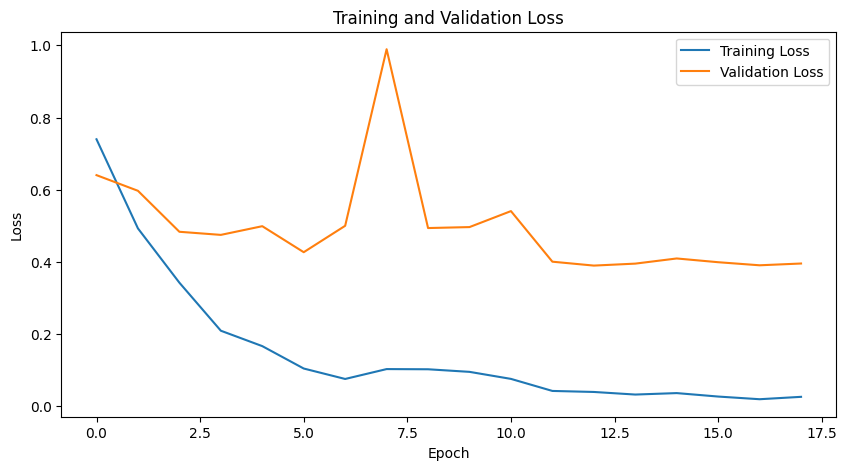

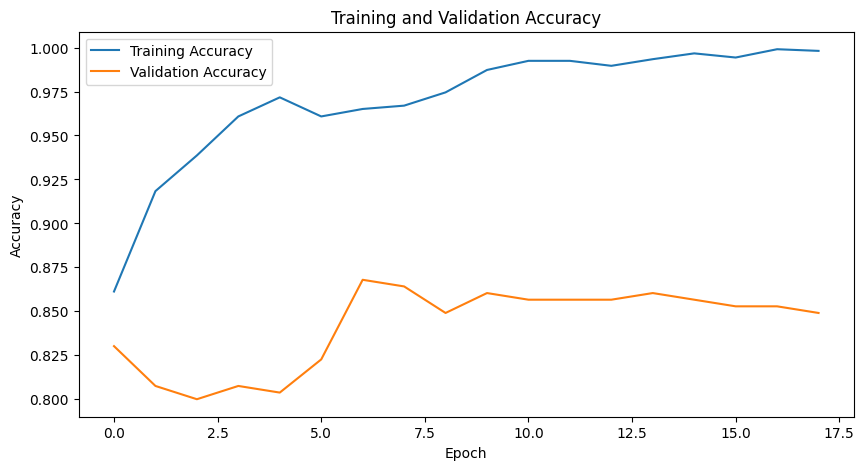

In [7]:
max_loss_threshold = 2.0
min_accuracy_threshold = 0.8

filtered_train_loss = [v for v in history.history['loss'] if v <= max_loss_threshold]
filtered_val_loss = [v for v in history.history['val_loss'] if v <= max_loss_threshold]

filtered_train_accuracy = [v for v in history.history['accuracy'] if v >= min_accuracy_threshold]
filtered_val_accuracy = [v for v in history.history['val_accuracy'] if v >= min_accuracy_threshold]

min_len = min(len(filtered_train_loss), len(filtered_val_loss), len(filtered_train_accuracy), len(filtered_val_accuracy))
filtered_train_loss = filtered_train_loss[:min_len]
filtered_val_loss = filtered_val_loss[:min_len]
filtered_train_accuracy = filtered_train_accuracy[:min_len]
filtered_val_accuracy = filtered_val_accuracy[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(filtered_train_loss, label='Training Loss')
plt.plot(filtered_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(filtered_train_accuracy, label='Training Accuracy')
plt.plot(filtered_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [8]:
model.load_weights('best_model.keras')

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.6875 - loss: 1.0427

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.8399 - loss: 0.4892
Test Loss: 0.4263, Test Accuracy: 0.85%
